In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import mitsuba as mi

# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

In [2]:
########## 加载具体的光追场景################
scene = load_scene('./Indoor/indoor.xml') # Try also sionna.rt.scene.etoile
# scene.preview()

In [3]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[0,0,2.95])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[0,0,2.95])
################ 将接收机加入到场景中##############
scene.add(rx)
rx1 = Receiver(name="rx1",
                position=[0,0,0])
scene.add(rx1)
tx.look_at(rx1)
rx.look_at(rx1)
scene.remove('rx1')

In [4]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [5]:
################计算光线传播路径################
paths = scene.compute_paths(max_depth=4,
                            num_samples=1e5,
                            reflection = True,
                            scattering = True,
                            diffraction=True)  # Number of rays shot into directions defined
                                              # by a Fibonacci spheree , too few rays can
                                              # lead to missing paths
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

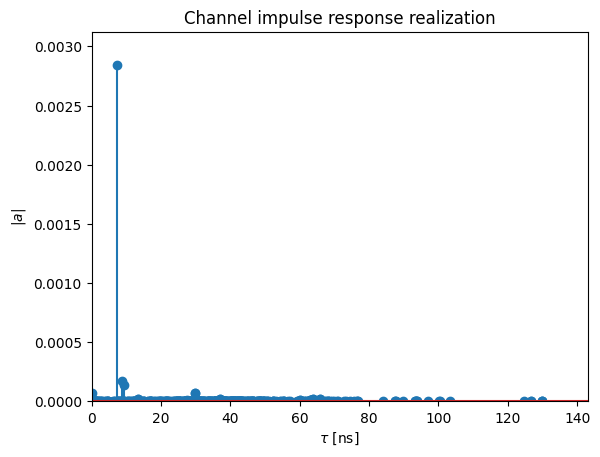

In [6]:
a, tau = paths.cir()
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [7]:
# 获取obj_names和wedges_names,要注意在xml文件里的名字必须是'mesh-名字-XXX'，XXX是任意字符串
mi_scene =scene.mi_scene
objects=paths.objects
wedges_2_objects = scene._solver_paths._wedges_objects
wedges_names = []
obj_names = []

for i,s in enumerate(mi_scene.shapes()):
    if not isinstance(s, mi.Mesh):
        raise ValueError('Only triangle meshes are supported')
    name = s.id().split('-')[1] 
    obj_names.append(name)

for [obj1,obj2] in wedges_2_objects:
    if obj1==obj2:
        wedges_names.append(obj_names[obj1])
    else:
        wedges_names.append(obj_names[obj1]+'&'+obj_names[obj2])

In [8]:
#[batch_size,max_num_paths]
# 0 : LoS
# 1 : Reflected
# 2 : Diffracted
# 3 : Scattered
types=paths.types[0]
# 确定数组维度
a, _, _, b = objects.shape
# 创建一个填充了 'None' 的默认数组
paths_obj_names = tf.fill(objects.shape, 'None')
# 为 obj_names 和 wedges_names 添加 'None' 选项以处理 -1 的情况
obj_names = tf.concat([obj_names, tf.constant(['None'])], axis=0)
wedges_names = tf.concat([wedges_names, tf.constant(['None'])], axis=0)
# 根据 types 和 objects 更新 paths_obj_names
for i in range(b):
    type_val = types[i]
    object_col = objects[:, :, :, i]

    # 生成用于更新的 indices
    indices = tf.where(tf.ones_like(object_col, dtype=tf.bool))
    b_col = tf.fill([indices.shape[0],1], i)
    indices = tf.concat([indices, tf.cast(b_col, tf.int64)], axis=1)
    # 根据 type 更新 paths_obj_names
    if type_val == 0:
        continue
    elif type_val in [1, 3]:
        # 将 -1 替换为指向 'None' 的下标
        object_col = tf.where(object_col == -1, tf.shape(obj_names)[0] - 1, object_col)
        updates = tf.gather(obj_names, tf.reshape(object_col, [-1]))
        paths_obj_names = tf.tensor_scatter_nd_update(paths_obj_names, indices, updates)
    elif type_val == 2:
        # 将 -1 替换为指向 'None' 的下标
        object_col = tf.where(object_col == -1, tf.shape(wedges_names)[0] - 1, object_col)
        updates = tf.gather(wedges_names, tf.reshape(object_col, [-1]))
        paths_obj_names = tf.tensor_scatter_nd_update(paths_obj_names, indices, updates)
# 打印结果
paths_obj_names

<tf.Tensor: shape=(4, 1, 1, 466), dtype=string, numpy=
array([[[[b'table1', b'table1', b'floor', ..., b'ceiling', b'ceiling',
          b'ceiling']]],


       [[[b'ceiling', b'ceiling', b'wall2', ..., b'table1', b'table1',
          b'table1']]],


       [[[b'table1', b'table1', b'ceiling', ..., b'ceiling',
          b'ceiling', b'ceiling']]],


       [[[b'None', b'None', b'None', ..., b'wall1', b'table1',
          b'table1']]]], dtype=object)>

In [11]:
types = paths.types[0]
paths_obj_names = tf.fill(objects.shape, 'None')
types_repeat = tf.repeat(tf.expand_dims(types, axis=0), repeats=objects.shape[2], axis=0)
types_repeat = tf.repeat(tf.expand_dims(types_repeat, axis=0), repeats=objects.shape[1], axis=0)
types_repeat = tf.repeat(tf.expand_dims(types_repeat, axis=0), repeats=objects.shape[0], axis=0)
mask_diff = tf.where(types_repeat == 2, True, False)
mask_diff = tf.logical_and(mask_diff, objects != -1)
mask_ref_scatt = tf.where(tf.logical_or(types_repeat == 1, types_repeat == 3), True, False)
mask_ref_scatt = tf.logical_and(mask_ref_scatt, objects != -1)
indices_diff = tf.where(mask_diff)
indices_ref_scatt = tf.where(mask_ref_scatt)
updates_diff = tf.gather(wedges_names, tf.reshape(objects[mask_diff], [-1]))
updates_ref_scatt = tf.gather(obj_names, tf.reshape(objects[mask_ref_scatt], [-1]))
paths_obj_names = tf.tensor_scatter_nd_update(paths_obj_names, indices_diff, updates_diff)
paths_obj_names = tf.tensor_scatter_nd_update(paths_obj_names, indices_ref_scatt, updates_ref_scatt)


<tf.Tensor: shape=(4, 1, 1, 466), dtype=string, numpy=
array([[[[b'table1', b'table1', b'floor', ..., b'ceiling', b'ceiling',
          b'ceiling']]],


       [[[b'ceiling', b'ceiling', b'wall2', ..., b'table1', b'table1',
          b'table1']]],


       [[[b'table1', b'table1', b'ceiling', ..., b'ceiling',
          b'ceiling', b'ceiling']]],


       [[[b'None', b'None', b'None', ..., b'wall1', b'table1',
          b'table1']]]], dtype=object)>